# 3D Shape/Scene Captioning
## 0. settings

In [1]:
import pandas 
import numpy as np
import os
import re
import operator
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from data import *
from constants import *
from models import *
from solver import *
import torchvision.models as torchmodels
import matplotlib.pyplot as plt

/home/davech2y/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
root = "/mnt/raid/davech2y/ShapeNetCore_vol/nrrd_256_filter_div_32_solid/"
sizes = [
    [100, 100, 100]
]

In [4]:
datasets = []
for i, size in enumerate(sizes):
    datasets.append(Caption(pandas.read_csv("captions.tablechair.csv"), size))
    print("[set %d]: total_size: %d, train_size: %d, valid_size: %d, test_size: %d, vocal_size: %d" 
          % (i+1, 
             datasets[-1].total_size, 
             datasets[-1].train_size, 
             datasets[-1].valid_size,
             datasets[-1].test_size,
             datasets[-1].dict_size))

[set 1]: total_size: 300, train_size: 100, valid_size: 100, test_size: 100, vocal_size: 545


In [2]:
temp = torchmodels.vgg16_bn(pretrained=True)
temp

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [5]:
import pandas 
import numpy as np
import os
import re
import operator
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from data import *
from constants import *
from models import *
from solver import *
import torchvision.models as torchmodels
import matplotlib.pyplot as plt

In [10]:
class AttentionDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, cuda_flag=True):
        super(AttentionDecoder, self).__init__()
        # basic settings
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cuda_flag = cuda_flag
        # layer settings
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.attention = nn.Linear((num_layers + 1) * hidden_size, hidden_size)
        self.lstm_layer = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, input_size)

    def forward(self, visual_inputs, caption_inputs):
        seq_length = caption_inputs.size(1)
        batch = visual_inputs.size(0)
        states = (
            torch.zeros(decoder.num_layers, batch, decoder.hidden_size).cuda(),
            torch.zeros(decoder.num_layers, batch, decoder.hidden_size).cuda()
        )
        decoder_outputs = []
        for step in range(seq_length):
            # get the attention weights
            if self.cuda_flag:
                hidden = states[0].permute(1, 0, 2).contiguous().view(batch, -1).cuda()
            else:
                hidden = states[0].permute(1, 0, 2).contiguous().view(batch, -1)
            attention_inputs = torch.cat((visual_inputs, hidden), dim=1)
            attention_weight = F.softmax(self.attention(attention_inputs), dim=1)
            # embed words
            embedded = self.embedding(caption_inputs[:, step])
            # apply attention weights
            attended = embedded * attention_weight
            # feed into LSTM
            outputs, states = self.lstm_layer(attended.unsqueeze(1), states)
            # get predicted probabilities
            outputs = self.output_layer(outputs.squeeze(1)).unsqueeze(1)
            decoder_outputs.append(outputs)
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        
        return decoder_outputs

root = "/mnt/raid/davech2y/ShapeNetCore_vol/nrrd_256_filter_div_32_solid/"
batch_size = 10
train_size = 100
valid_size = 100
coco = COCO(
    pandas.read_csv("/mnt/raid/davech2y/COCO_2014/preprocessed/coco_train2014.caption.csv"), 
    pandas.read_csv("/mnt/raid/davech2y/COCO_2014/preprocessed/coco_valid2014.caption.csv"),
    [train_size, valid_size]
)
# split data
train_captions = coco.transformed_data['train']
valid_captions = coco.transformed_data['valid']
dictionary = coco.dict_idx2word
corpus = coco.corpus
# prepare the dataloader
train_ds = COCOCaptionDataset(
    root, 
    train_captions, 
    database="/mnt/raid/davech2y/COCO_2014/preprocessed/coco_train2014_224.hdf5"
)
valid_ds = COCOCaptionDataset(
    root, 
    valid_captions,
    database="/mnt/raid/davech2y/COCO_2014/preprocessed/coco_valid2014_224.hdf5"
)
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
dataloader = {
    'train': train_dl,
    'valid': valid_dl
}
# encoder
encoder = EncoderResnet50().cuda()
# decoder
input_size = dictionary.__len__() + 1
hidden_size = 512
num_layer = 2
decoder = AttentionDecoder(input_size, hidden_size, num_layer).cuda()
# criterion
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.fc_layer.parameters()), lr=1e-2)
loss = 0

In [11]:
for epoch_id in range(200):
    running_loss = []
    for model_ids, visuals, captions, cap_lengths in train_dl:
        visual_inputs = Variable(visuals).cuda()
        caption_inputs = torch.cat([item.view(1, -1) for item in captions]).transpose(1, 0)[:, :cap_lengths[0]-1].cuda()
        caption_targets = torch.cat([item.view(1, -1) for item in captions]).transpose(1, 0)[:, 1:cap_lengths[0]].cuda()
        caption_inputs = Variable(caption_inputs).cuda()
        visual_contexts = encoder.extract(visual_inputs)
        decoder_outputs = decoder(visual_contexts, caption_inputs)
        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(2)), caption_targets.contiguous().view(-1))
        running_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        break
    print("epoch: %d, loss: %f" % (epoch_id+1, np.mean(running_loss)))

epoch: 1, loss: 6.458945
epoch: 2, loss: 5.531746
epoch: 3, loss: 4.441280
epoch: 4, loss: 4.710087
epoch: 5, loss: 4.554115
epoch: 6, loss: 4.440136
epoch: 7, loss: 4.498253
epoch: 8, loss: 4.369538
epoch: 9, loss: 4.324200
epoch: 10, loss: 4.362049
epoch: 11, loss: 4.308634
epoch: 12, loss: 4.214308
epoch: 13, loss: 4.179701
epoch: 14, loss: 4.149616
epoch: 15, loss: 4.127750
epoch: 16, loss: 4.101233
epoch: 17, loss: 4.034001
epoch: 18, loss: 3.960799
epoch: 19, loss: 3.920811
epoch: 20, loss: 3.898651
epoch: 21, loss: 4.056988
epoch: 22, loss: 3.926312
epoch: 23, loss: 3.868804
epoch: 24, loss: 4.198662
epoch: 25, loss: 3.851800
epoch: 26, loss: 3.854007
epoch: 27, loss: 3.856647
epoch: 28, loss: 3.848182
epoch: 29, loss: 3.807989
epoch: 30, loss: 3.774233
epoch: 31, loss: 3.751536
epoch: 32, loss: 3.731441
epoch: 33, loss: 3.708813
epoch: 34, loss: 3.683813
epoch: 35, loss: 3.676919
epoch: 36, loss: 3.670010
epoch: 37, loss: 3.658523
epoch: 38, loss: 3.635969
epoch: 39, loss: 3.62

In [1]:
caption_targets

NameError: name 'caption_targets' is not defined

In [13]:
_, temp = torch.max(decoder_outputs, 2)
temp


    1    34   418    68     1   185   209    35     4     3
    1   423    33     1    61    93   424    42     4     3
  427   428   429   430     7     8    69   184     4     3
    1    74     5   431    16     7     1    69    97     3
    1    20    52    73     6     1    58    21     4     3
   91    16    40   419   211   209     1   134     3     3
   12   145     6     1    60     9   149   420     3     3
    1    74    94     5   421   422    12   193     3     3
    1    74   213   426     6     1   146    21     3   263
   12   432   433     6     1   434   207   435     3     3
[torch.cuda.LongTensor of size (10,10) (GPU 0)]

In [4]:
# prepare the dataloader
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
train_ds = ImageCaptionDataset(root, datasets[-1].transformed_data['train'], transform)
train_dl = DataLoader(train_ds, batch_size=50)
valid_ds = ImageCaptionDataset(root, datasets[-1].transformed_data['valid'], transform)
valid_dl = DataLoader(valid_ds, batch_size=50)
dataloader = {
    'train': train_dl,
    'valid': valid_dl
}

# # load the pretrained encoder
# encoder = torch.load("data/encoder.pth").cuda()

# initialize the encoder
encoder = Encoder2D().cuda()

# define the decoder
input_size = datasets[-1].dict_size + 1
hidden_size = 512
num_layer = 2
decoder = Decoder(input_size, hidden_size, num_layer).cuda()

# prepare the training parameters
# optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.fc_layer.parameters()), lr=0.001)
params = list(decoder.parameters()) + list(encoder.conv_layer.parameters()) + list(encoder.fc_layer.parameters())
optimizer = optim.Adam(params, lr=0.0001)
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
epoch = 100
verbose = 10

# training
encoder_decoder_solver = EncoderDecoderSolver(optimizer, criterion, model_type="3d")

In [5]:
dictionary = datasets[-1].dict_idx2word
candidates = {
    'train': {},
    'valid': {}
}
for phase in ["train", "valid"]:
    for model_ids, visuals, captions, cap_lengths in dataloader[phase]:
        caption_inputs = torch.cat([item.view(1, -1) for item in captions]).transpose(1, 0)[:, :cap_lengths[0]-1]
        caption_targets = torch.cat([item.view(1, -1) for item in captions]).transpose(1, 0)[:, :cap_lengths[0]]
        visual_inputs = Variable(visuals).cuda()
        caption_inputs = Variable(caption_inputs).cuda()
        caption_targets = Variable(caption_targets).cuda()
        caption_targets, pack_info = pack_padded_sequence(caption_targets, cap_lengths, batch_first=True)
        cap_lengths = Variable(cap_lengths).cuda()
        visual_contexts = encoder.extract(visual_inputs)
        outputs, _ = decoder(visual_contexts, caption_inputs, cap_lengths)
        outputs = encoder_decoder_solver._decode_outputs(outputs.max(1)[1], pack_info, cap_lengths, dictionary)
        for model_id, output in zip(model_ids, outputs):
            if model_id not in candidates[phase].keys():
                candidates[phase][model_id] = [output]
            else:
                candidates[phase][model_id].append(output)

## 1. 2D encoder-decoder for image captioning

In [ ]:
###################################################################
#                                                                 #
#                                                                 #
#                   training for encoder-decoder                  #
#                                                                 #
#                                                                 #
###################################################################

train_log = []
models = []
for data in datasets:
    print("[Info] train_size: %d, valid_size: %d, dict_size: %d\n" % 
          (data.train_size, data.valid_size, data.dict_size))
    
    # prepare the dataloader
    transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
    train_ds = ImageCaptionDataset(root, data.transformed_data['train'], transform)
    train_dl = DataLoader(train_ds, batch_size=50)
    valid_ds = ImageCaptionDataset(root, data.transformed_data['valid'], transform)
    valid_dl = DataLoader(valid_ds, batch_size=50)
    dataloader = {
        'train': train_dl,
        'valid': valid_dl
    }

    # # load the pretrained encoder
    # encoder = torch.load("data/encoder.pth").cuda()

    # initialize the encoder
    encoder = Encoder2D().cuda()

    # define the decoder
    input_size = data.dict_size + 1
    hidden_size = 512
    num_layer = 2
    decoder = Decoder(input_size, hidden_size, num_layer).cuda()

    # prepare the training parameters
    # optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.fc_layer.parameters()), lr=0.001)
    params = list(decoder.parameters()) + list(encoder.conv_layer.parameters()) + list(encoder.fc_layer.parameters())
    optimizer = optim.Adam(params, lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.NLLLoss()
    epoch = 100
    verbose = 10

    # training
    encoder_decoder_solver = EncoderDecoderSolver(optimizer, criterion, model_type="3d")
    encoder_decoder_solver.train(encoder, decoder, dataloader, data.corpus, data.dict_idx2word, epoch, verbose, model_type="3d")
    
    # save
    train_log.append(encoder_decoder_solver.log)
    models.append((encoder, decoder))
    print()

In [8]:
sum([np.prod(p.size()) for p in encoder.parameters()])

2719234

In [9]:
sum(p.numel() for p in encoder.parameters() if p.requires_grad)

2719234

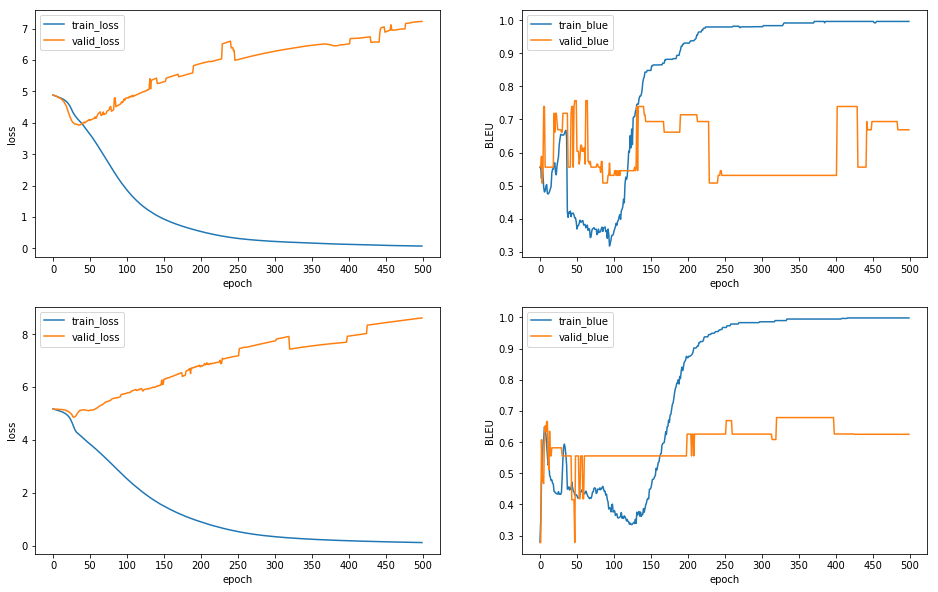

In [18]:
# plot the result
fig = plt.gcf()
fig.set_size_inches(16,10)
for i in range(2):
    plt.subplot(2, 2, i * 2 + 1)
    plt.plot(range(epoch), [train_log[i][j]["train_loss"] for j in range(epoch)], label="train_loss")
    plt.plot(range(epoch), [train_log[i][j]["valid_loss"] for j in range(epoch)], label="valid_loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xticks(range(0, epoch + 1, math.floor(epoch / 10)))
    plt.legend()
    plt.subplot(2, 2, i * 2 + 2)
    plt.plot(range(epoch), [train_log[i][j]["train_blue"] for j in range(epoch)], label="train_blue")
    plt.plot(range(epoch), [train_log[i][j]["valid_blue"] for j in range(epoch)], label="valid_blue")
    plt.xlabel('epoch')
    plt.ylabel('BLEU')
    plt.xticks(range(0, epoch + 1, math.floor(epoch / 10)))
    plt.legend()
    
plt.show()

In [57]:
###################################################################
#                                                                 #
#                                                                 #
#       caption generating via encoder-decoder pipeline           #
#                                                                 #
#                                                                 #
###################################################################

# initialize the pipeline
encoder_path = "data/encoder_checkpoint_2d.pth"
decoder_path = "data/decoder_checkpoint_2d.pth"
encoder_decoder = EncoderDecoder(encoder_path, decoder_path)

# prepare the dataloader
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
train_ds = ImageCaptionDataset(root, datasets[-1].transformed_data['train'], transform)
train_dl = DataLoader(train_ds, batch_size=1)
valid_ds = ImageCaptionDataset(root, datasets[-1].transformed_data['test'], transform)
valid_dl = DataLoader(valid_ds, batch_size=1)
dataloader = {
    'train': train_dl,
    'test': valid_dl
}

# caption images
descriptions = {
    'train': [],
    'test': []
}
images = {
    'train': [],
    'test': []
}
for phase in ["train", "test"]:
    for i, (_, image_inputs, caps, cap_lengths) in enumerate(dataloader[phase]):
        image_inputs = Variable(image_inputs).cuda()
        descriptions[phase] += encoder_decoder.generate_text(image_inputs, datasets[-1].dict_idx2word, 50)
        images[phase].append(image_inputs)
        
    # edit the descriptions
    for i in range(len(descriptions[phase])):
        text = descriptions[phase][i].split(" ")
        new = []
        count = 0
        for j in range(len(text)):
            new.append(text[j])
            count += 1
            if count == 12:
                new.append("\n")
                count = 0
        descriptions[phase][i] = " ".join(new)

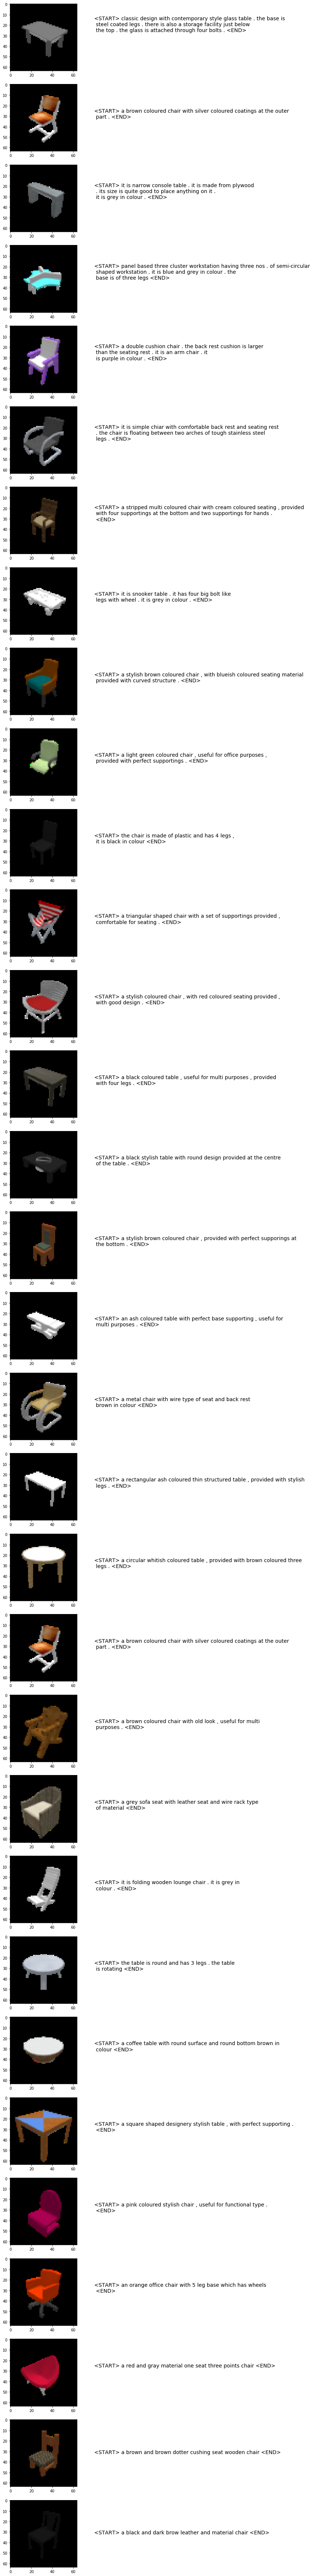

In [60]:
fig = plt.gcf()
fig.set_size_inches(8,4 * len(descriptions['train']))
fig.set_facecolor('white')
for i in range(len(descriptions['train'])):
    plt.subplot(len(descriptions['train']), 1, i+1)
    plt.imshow(transforms.ToPILImage()(images['train'][i].cpu().view(3, 64, 64)))
    plt.text(80, 32, descriptions['train'][i], fontsize=14)
plt.show()

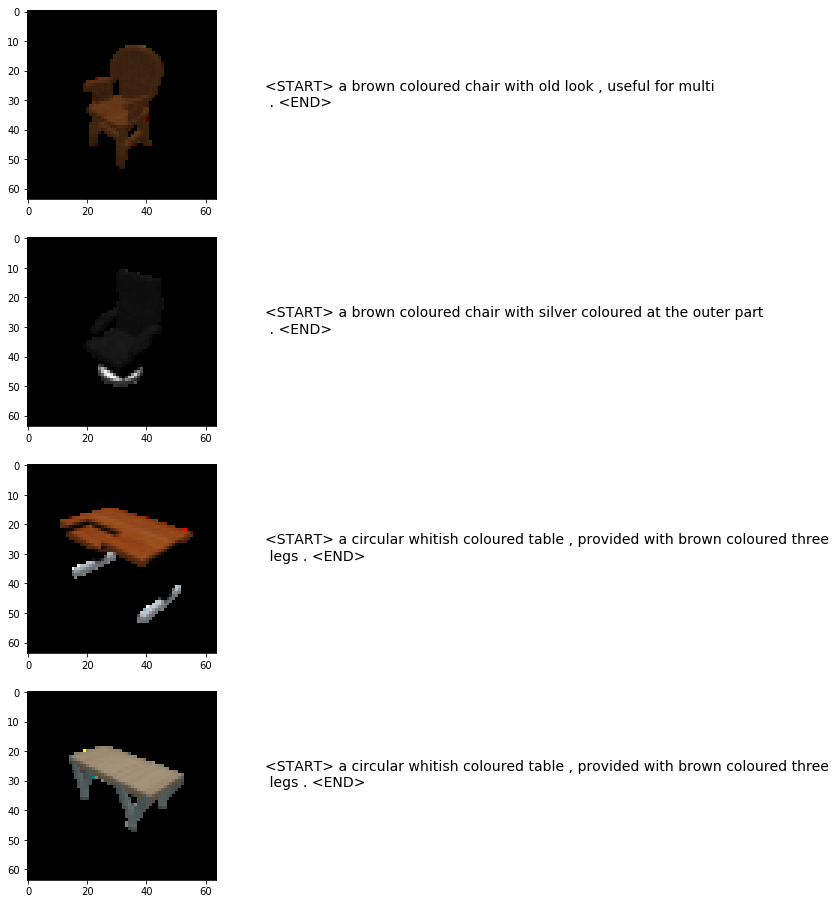

In [61]:
fig = plt.gcf()
fig.set_size_inches(8,4 * len(descriptions['test']))
fig.set_facecolor('white')
for i in range(len(descriptions['test'])):
    plt.subplot(len(descriptions['test']), 1, i+1)
    plt.imshow(transforms.ToPILImage()(images['test'][i].cpu().view(3, 64, 64)))
    plt.text(80, 32, descriptions['test'][i], fontsize=14)
plt.show()

## 2. 3D encoder-decoder for shape captioning

In [15]:
###################################################################
#                                                                 #
#                                                                 #
#                   training for encoder-decoder                  #
#                                                                 #
#                                                                 #
###################################################################

train_log = []
for data in datasets:
    print("[Info] train_size: %d, valid_size: %d, dict_size: %d\n" % 
          (data.train_size, data.valid_size, data.dict_size))
    
    # prepare the dataloader
    train_ds = ShapeCaptionDataset(
        root, 
        data.transformed_data['train'],
        mode="hdf5", 
        database="/mnt/raid/davech2y/ShapeNetCore_vol/nrrd_256_filter_div_32_solid.hdf5"
    )
    train_dl = DataLoader(train_ds, batch_size=2)
    valid_ds = ShapeCaptionDataset(
        root, 
        data.transformed_data['valid'],
        mode="hdf5", 
        database="/mnt/raid/davech2y/ShapeNetCore_vol/nrrd_256_filter_div_32_solid.hdf5"
    )
    valid_dl = DataLoader(valid_ds, batch_size=2)
    dataloader = {
        'train': train_dl,
        'valid': valid_dl
    }

    # # load the pretrained encoder
    # encoder = torch.load("data/encoder.pth").cuda()

    # initialize the encoder
    encoder = Encoder3D().cuda()

    # define the decoder
    input_size = data.dict_size + 1
    hidden_size = 512
    num_layer = 2
    decoder = Decoder(input_size, hidden_size, num_layer).cuda()

    # prepare the training parameters
    # optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.fc_layer.parameters()), lr=0.001)
    params = list(decoder.parameters()) + list(encoder.conv_layer.parameters()) + list(encoder.fc_layer.parameters())
    optimizer = optim.Adam(params, lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.NLLLoss()
    epoch = 200
    verbose = 10

    # training
    encoder_decoder_solver = EncoderDecoderSolver(optimizer, criterion, model_type="3d")
    encoder_decoder_solver.train(encoder, decoder, dataloader, data.corpus, data.dict_idx2word, epoch, verbose, model_type="3d")
    
    # save
    train_log.append(encoder_decoder_solver.log)
    torch.save(encoder, "models/encoder_jupyter_%s_ts%d_bs%d_vocal%d.pth"  % ("3d", data.train_size, epoch, input_size))
    torch.save(decoder, "models/decoder_jupyter_%s_ts%d_bs%d_vocal%d.pth"  % ("3d", data.train_size, epoch, input_size))
    print()

[Info] train_size: 16, valid_size: 2, dict_size: 132

---------------------epoch 10/200----------------------
[train] train_loss: 3.587133, train_blue: 0.414685
[valid] valid_loss: 4.141116, valid_blue: 0.555711
[Info]  forward_per_epoch: 0.037514s
[Info]  backward_per_epoch: 0.106376s
[Info]  valid_per_epoch: 0.015946s
[Info]  time_per_epoch: 0.194804s
[Info]  ETA: 0m 37s 

---------------------epoch 20/200----------------------
[train] train_loss: 2.430432, train_blue: 0.395789
[valid] valid_loss: 4.797477, valid_blue: 0.548014
[Info]  forward_per_epoch: 0.037708s
[Info]  backward_per_epoch: 0.108008s
[Info]  valid_per_epoch: 0.016764s
[Info]  time_per_epoch: 0.198072s
[Info]  ETA: 0m 35s 

---------------------epoch 30/200----------------------
[train] train_loss: 1.678464, train_blue: 0.403981
[valid] valid_loss: 5.001642, valid_blue: 0.714288
[Info]  forward_per_epoch: 0.035702s
[Info]  backward_per_epoch: 0.106829s
[Info]  valid_per_epoch: 0.016963s
[Info]  time_per_epoch: 0.1933

---------------------epoch 60/200----------------------
[train] train_loss: 0.494603, train_blue: 0.875528
[valid] valid_loss: 7.042489, valid_blue: 0.696119
[Info]  forward_per_epoch: 0.073300s
[Info]  backward_per_epoch: 0.218994s
[Info]  valid_per_epoch: 0.024537s
[Info]  time_per_epoch: 0.387882s
[Info]  ETA: 0m 54s 

---------------------epoch 70/200----------------------
[train] train_loss: 0.320219, train_blue: 0.907366
[valid] valid_loss: 7.309795, valid_blue: 0.696119
[Info]  forward_per_epoch: 0.071638s
[Info]  backward_per_epoch: 0.222020s
[Info]  valid_per_epoch: 0.030882s
[Info]  time_per_epoch: 0.391504s
[Info]  ETA: 0m 50s 

---------------------epoch 80/200----------------------
[train] train_loss: 0.223643, train_blue: 0.950481
[valid] valid_loss: 7.563165, valid_blue: 0.696119
[Info]  forward_per_epoch: 0.073713s
[Info]  backward_per_epoch: 0.224578s
[Info]  valid_per_epoch: 0.022939s
[Info]  time_per_epoch: 0.391283s
[Info]  ETA: 0m 46s 

---------------------epoch 9

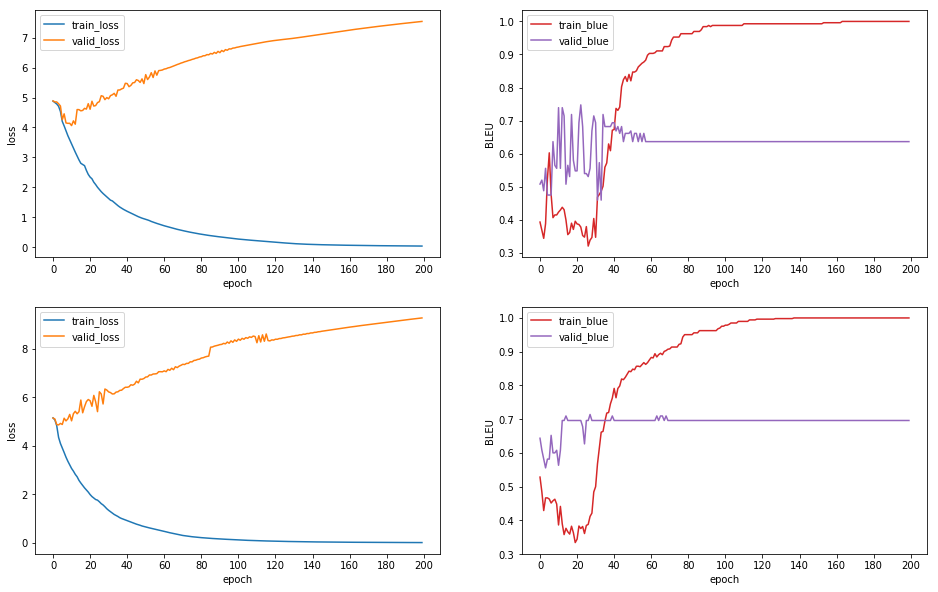

In [23]:
# plot the result
fig = plt.gcf()
fig.set_size_inches(16,10)
for i in range(2):
    plt.subplot(2, 2, i * 2 + 1)
    plt.plot(range(epoch), [train_log[i][j]["train_loss"] for j in range(epoch)], label="train_loss")
    plt.plot(range(epoch), [train_log[i][j]["valid_loss"] for j in range(epoch)], label="valid_loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xticks(range(0, epoch + 1, math.floor(epoch / 10)))
    plt.legend()
    plt.subplot(2, 2, i * 2 + 2)
    plt.plot(range(epoch), [np.mean(train_log[i][j]["train_blue"]) for j in range(epoch)], "C3", label="train_blue")
    plt.plot(range(epoch), [np.mean(train_log[i][j]["valid_blue"]) for j in range(epoch)], "C4", label="valid_blue")
    plt.xlabel('epoch')
    plt.ylabel('BLEU')
    plt.xticks(range(0, epoch + 1, math.floor(epoch / 10)))
    plt.legend()
    
plt.show()

In [29]:
###################################################################
#                                                                 #
#                                                                 #
#       caption generating via encoder-decoder pipeline           #
#                                                                 #
#                                                                 #
###################################################################

# initialize the pipeline
encoder_path = "models/encoder_jupyter_3d_ts32_bs200_vocal176.pth"
decoder_path = "models/decoder_jupyter_3d_ts32_bs200_vocal176.pth"
encoder_decoder = EncoderDecoder(encoder_path, decoder_path)
dataset = datasets[1]

# prepare the dataloader
train_ds = ShapeCaptionDataset(
        root, 
        dataset.transformed_data['train'],
        mode="hdf5", 
    )
train_dl = DataLoader(train_ds, batch_size=1)
valid_ds = ShapeCaptionDataset(
        root, 
        dataset.transformed_data['test'],
        mode="hdf5", 
        database="/mnt/raid/davech2y/ShapeNetCore_vol/nrrd_256_filter_div_32_solid.hdf5"
    )
valid_dl = DataLoader(valid_ds, batch_size=1)
dataloader = {
    'train': train_dl,
    'test': valid_dl
}

# caption shapes
descriptions = {
    'train': [],
    'test': []
}
images = {
    'train': [],
    'test': []
}
for phase in ["train", "test"]:
    for i, (_, visual_inputs, caps, cap_lengths) in enumerate(dataloader[phase]):
        shape_inputs = Variable(visual_inputs[1]).cuda()
        descriptions[phase] += encoder_decoder.generate_text(shape_inputs, dataset.dict_idx2word, 50)
        images[phase].append(visual_inputs[0][0])
        
    # edit the descriptions
    for i in range(len(descriptions[phase])):
        text = descriptions[phase][i].split(" ")
        new = []
        count = 0
        for j in range(len(text)):
            new.append(text[j])
            count += 1
            if count == 12:
                new.append("\n")
                count = 0
        descriptions[phase][i] = " ".join(new)

In [42]:
fig = plt.gcf()
fig.set_size_inches(8,4 * len(descriptions['test']))
fig.set_facecolor('white')
for i in range(len(descriptions['train'])):
    plt.subplot(len(descriptions['train']), 1, i+1)
    plt.Image.open(images['train'][i]).resize((64, 64))
    plt.text(80, 32, descriptions['train'][i], fontsize=14)
fig.show()

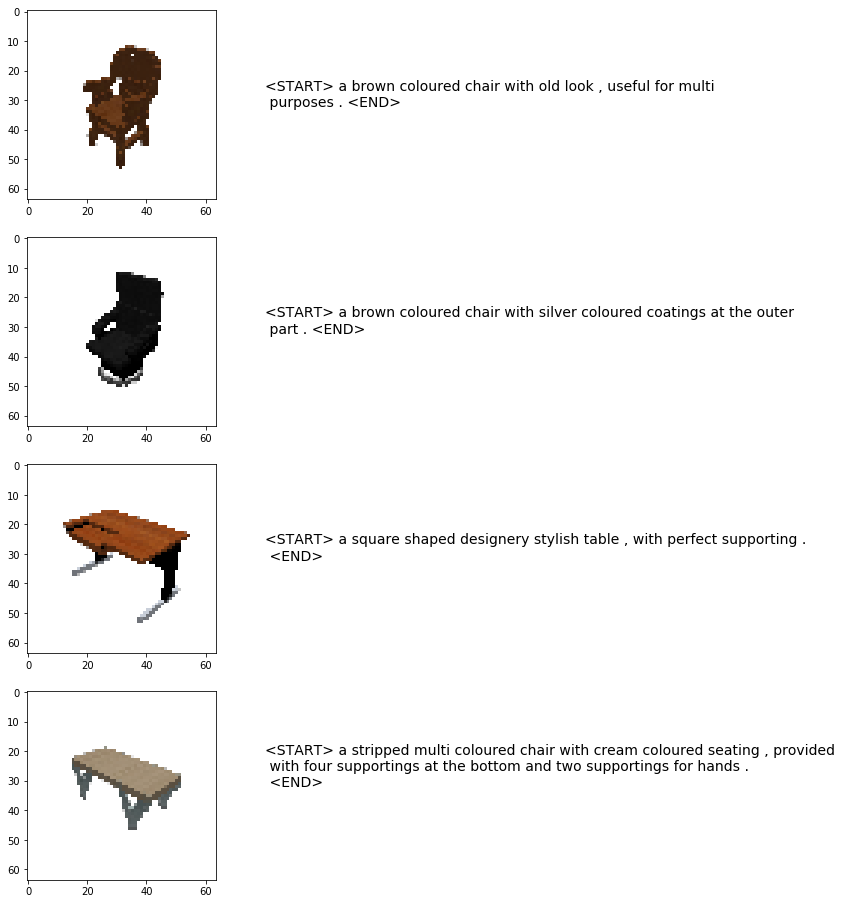

In [31]:
fig = plt.gcf()
fig.set_size_inches(8,4 * len(descriptions['test']))
fig.set_facecolor('white')
for i in range(len(descriptions['test'])):
    plt.subplot(len(descriptions['test']), 1, i+1)
    plt.imshow(Image.open(images['test'][i]).resize((64, 64)))
    plt.text(80, 32, descriptions['test'][i], fontsize=14)
plt.show()